In [62]:
#This is the works for Udacity Self-driving-car-nd Term1 Project 3.
%matplotlib inline
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

### Dataset

In [2]:
#Folder_path = "./dataset/behavioral-cloning/train_data/"
Folder_path = "./dataset/behavioral-cloning/sample_data/"
Img_path = Folder_path + "IMG/"
#df = pd.read_csv(Folder_path + "driving_log.csv", names=['center', 'left', 'right', 'steer', 'gas', 'brake', 'speed'])
df = pd.read_csv(Folder_path + "driving_log.csv")


In [3]:
df['left'] = df['left'].str.replace(' IMG/','./dataset/behavioral-cloning/sample_data/IMG/')
df['right'] = df['right'].str.replace(' IMG/','./dataset/behavioral-cloning/sample_data/IMG/')
df['center'] = df['center'].str.replace('IMG/','./dataset/behavioral-cloning/sample_data/IMG/')

In [4]:
df

,center,left,right,steering,throttle,brake,speed
0,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,22.148290
1,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,21.879630
2,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,1.453011
3,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,1.438419
4,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,1.418236
5,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,1.403993
6,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,1.389892
7,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,1.375934
8,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,1.362115
9,./dataset/behavioral-cloning/sample_data/IMG/c...,./dataset/behavioral-cloning/sample_data/IMG/l...,./dataset/behavioral-cloning/sample_data/IMG/r...,0.0,0.0,0.0,1.348435


In [5]:
#data balancing refer from https://navoshta.com/end-to-end-deep-learning/
balanced = pd.DataFrame()
bins = 1000
bin_n = 200

start = 0
for end in np.linspace(0, 1, num=bins):
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    if range_n > 0:
        balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end
balanced.to_csv(Folder_path + 'driving_log_balanced.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1f96fdfd0>]], dtype=object)

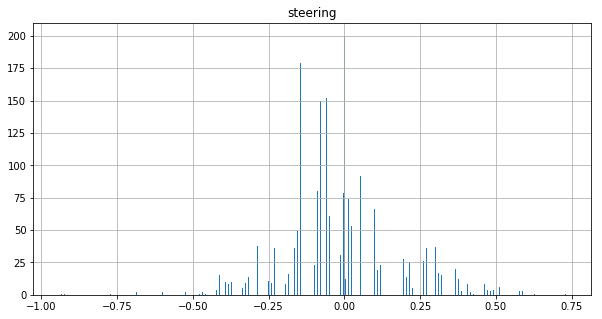

In [6]:
balanced.hist(column=['steering'], bins=1000, figsize=(10,5))

In [7]:
num_examples = len(df)
print("Number of examplese : {}".format(num_examples))

Number of examplese : 8036


### Data Augmentation

In [8]:
import random
import os, sys
import csv
from skimage.transform import rotate, warp, ProjectiveTransform, AffineTransform
from skimage.exposure import equalize_adapthist
#from scipy.misc import imresize
import cv2

In [9]:
def random_translate(X, steer, intensity=1):
    delta = 15.* intensity
    rand_delta = random.uniform(-delta, delta)
    translate_matrix = AffineTransform(translation=(0, rand_delta))
    X = warp(X,translate_matrix)
    steer = steer
    return X, steer

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff199364f28>,
 (-0.5, 319.5, 159.5, -0.5))

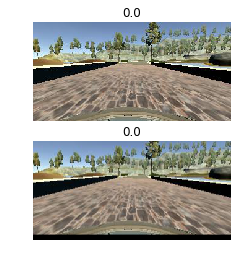

In [10]:
#test
ran_idx = random.randint(0, num_examples)
test_img = plt.imread(df.center[ran_idx])
test_str = float(df.steering[ran_idx])
test_rt_img, test_rt_str = random_translate(test_img, test_str)
plt.subplot(2,1,1), plt.imshow(test_img), plt.title(round(test_str,2)), plt.axis('off')
plt.subplot(2,1,2), plt.imshow(test_rt_img), plt.title(round(test_rt_str,2)), plt.axis('off')

In [11]:
def image_flip(X, steer):
    img_fliped = np.fliplr(X)
    str_fliped = -steer
    return img_fliped, str_fliped

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff1992af048>,
 (-0.5, 319.5, 159.5, -0.5),
 <matplotlib.text.Text at 0x7ff19818d470>)

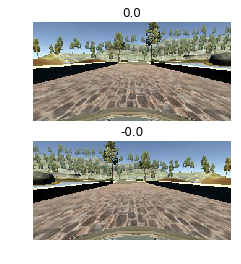

In [12]:
#test
test_fl_img, test_fl_str = image_flip(test_img, test_str)
plt.subplot(2,1,1), plt.imshow(test_img), plt.axis('off'), plt.title(round(test_str,2))
plt.subplot(2,1,2), plt.imshow(test_fl_img), plt.axis('off'), plt.title(round(test_fl_str,2))

In [13]:
import math
import cv2
def preprocess_image(X):
    shape = X.shape
    X = X[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    X = cv2.resize(X, (64,64), interpolation=cv2.INTER_AREA)
    
    return X

In [50]:
center = df.center.tolist()
left = df.left.tolist()
right = df.right.tolist()
steering = df.steering.tolist()
leftsteering = (df.steering + 0.25).tolist()
rightsteering = (df.steering - 0.25).tolist()

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
center, X_valid, steering, y_valid = train_test_split(center, steering, test_size=0.2)

X_train = center + left + right
y_train = steering + leftsteering + rightsteering

In [79]:
def random_brightness(image):
    #Convert 2 HSV colorspace from RGB colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #Generate new random brightness
    rand = random.uniform(0.3,1.0)
    hsv[:,:,2] = rand*hsv[:,:,2]
    #Convert back to RGB colorspace
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return new_img 

# Flip image around vertical axis
def flip(image, angle):
    new_image = cv2.flip(image,1)
    new_angle = angle*(-1)
    return new_image, new_angle

# Crop image to remove the sky and driving deck, resize to 64x64 dimension 
def crop_resize(image):
    cropped = cv2.resize(image[60:140,:], (64,64))
    return cropped

## GENERATORS FOR KERAS fit_generator() ##

# Training generator: shuffle training data before choosing data, pick random training data to feed into batch at each "for" loop.
# Apply random brightness, resize, crop into the chosen sample. Add some small random noise for chosen angle.

def generator_data(data, angle, batch_size):
    batch_train = np.zeros((batch_size, 64, 64, 3), dtype = np.float32)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        data, angle = shuffle(data, angle)
        for i in range(batch_size):
            choice = int(np.random.choice(len(data),1))
            batch_train[i] = crop_resize(random_brightness(mpimg.imread(data[choice].strip())))
            batch_angle[i] = angle[choice]*(1+ np.random.uniform(-0.10,0.10))
            #Flip random images#
            flip_coin = random.randint(0,1)
            if flip_coin == 1:
                batch_train[i], batch_angle[i] = flip(batch_train[i], batch_angle[i])

        yield batch_train, batch_angle

def generator_valid(data, angle, batch_size):
    batch_train = np.zeros((batch_size, 64, 64, 3), dtype = np.float32)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        data, angle = shuffle(data,angle)
        for i in range(batch_size):
            rand = int(np.random.choice(len(data),1))
            batch_train[i] = crop_resize(mpimg.imread(data[rand].strip()))
            batch_angle[i] = angle[rand]
        yield batch_train, batch_angle


In [90]:
batch_size = 128
train_generator = generator_data(X_train, y_train, batch_size)
validation_generator = generator_valid(X_valid, y_valid, batch_size)

In [14]:
samples = []
with open(Folder_path + "driving_log_balanced.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [16]:
def generator(df, batch_size=128):
    num_samples = len(df)
    while True:
        #shuffle(samples)
        for offset in range(1, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                i_lrc = np.random.randint(3)
                if(i_lrc == 0): #left
                    path_file = batch_sample[1]
                    str_offset = 0.25
                if(i_lrc == 1): #center
                    path_file = batch_sample[0]
                    str_offset = 0.
                if(i_lrc == 2): #right
                    path_file = batch_sample[2]
                    str_offset = -0.25
                
                img = cv2.imread(path_file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #img = plt.imread(path_file)
                ang = float(batch_sample[3]) + str_offset
                img, ang = random_translate(img, ang)
                if np.random.randint(2) == 0:
                    img, ang = image_flip(img, ang)
                
                img = preprocess_image(img)
                
                images.append(img)
                angles.append(ang)
                
                
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)
                

In [17]:
batch_size = 128
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [67]:
#test
for i in range(10):
    next(train_generator)
img,steer = next(train_generator)

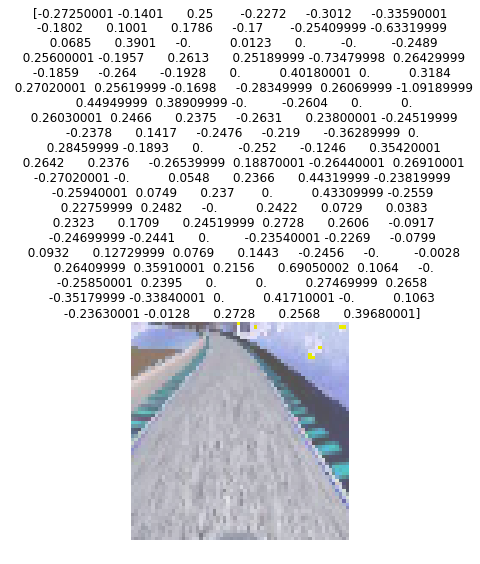

In [71]:
plt.imshow(img[1]);
plt.axis('off')
plt.title(str(np.round(steer,4)));

### Model

In [83]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten, Cropping2D
from keras.optimizers import adam

In [84]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers import Lambda

In [85]:
#Model Configurations
img_height = 64
img_width = 64
img_ch = 3

f_size = 3
learning_rate = 1e-2
activation = 'elu'

In [86]:
def build_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/255. -0.5, input_shape=(img_height, img_width, img_ch)))
    model.add(Conv2D(16,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(500, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation=activation))
    model.add(Dropout(0.25))
    model.add(Dense(20, activation=activation))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    model.summary()
    #model = make_parallel(model,2)
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    
    return model


In [87]:
model = build_model()
model_checkpoint = ModelCheckpoint('model.h5', monitor='loss', save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [91]:
model.fit_generator(train_generator,
                    steps_per_epoch=9000,#len(X_train),
                    validation_data=validation_generator,
                    validation_steps=2000,#len(X_valid),
                    callbacks=[model_checkpoint],
                    epochs=3)

Epoch 1/3
9000/9000 [==============================] - 3261s - loss: 0.0148 - acc: 0.1344 - val_loss: 0.0156 - val_acc: 0.5282
Epoch 2/3
6460/9000 [====================>.........] - ETA: 812s - loss: 0.0069 - acc: 0.1346

KeyboardInterrupt: 

In [93]:
with open('model.json', 'w') as file:
        file.write(model.to_json())

### Results